# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- 分類器としてそのまま使うことはできない（正解率6割程度）が、
- うまく予想することができている（LRを用いて求めた確率が高いところでは実際1が成立し、低いところでは0が成立する率が高い）

#### bet結果


In [32]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [33]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.make_merged_df()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["exhibitionTime_1"])

In [35]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # ラベルの数を変数名にしておく。labelと特徴量を分けるときに使う
    num_labels = len(column_list_label)

    # 解析用dfを作成
    fv_label_odds_df = the_merged_df[fv_list + column_list_label + odds_list]
    
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = fv_label_odds_df[fv_list + column_list_label ]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_label_df.replace(key, value, inplace = True)

    # なぜかdtypeがstrになっちゃうのでintに戻す
    fv_labe_df = fv_label_df.astype(float)

    # ラベルをbooleanに変換
    fv_label_df = analyzer_conf.make_label_boolean_ver1(
        fv_label_df, column_list_label)
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """        
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []
for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各枠の平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))

# 解析に使うラベルカラム: 今回は一枠が一着になるかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


解析用dfの行数は.26325


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

1号艇についてtrainデータを使った正解率は0.646388451728442,
           testデータを使った正解率は0.6458597113193213
切片は[0.13412659]
class_1 -0.5102350115792044 

aveST_frame1 -0.029466415522616203 

placeRate_frame1 0.0014243546528532843 

exhibitionTime_1 -3.1255511621637444 

class_2 0.053429282275702275 

aveST_frame2 -0.009140993584035613 

placeRate_frame2 -0.0004309315813193961 

exhibitionTime_2 0.9611174046203447 

class_3 0.04392506662742233 

aveST_frame3 0.005788432707352757 

placeRate_frame3 -0.00010941049180385057 

exhibitionTime_3 0.7910058431584388 

class_4 0.06348056536581641 

aveST_frame4 0.009412457029274762 

placeRate_frame4 -0.00025631591657635904 

exhibitionTime_4 1.1323844837549675 

class_5 0.06290934233060341 

aveST_frame5 0.006066878370011871 

placeRate_frame5 -0.0002468256097501976 

exhibitionTime_5 0.15660360693628636 

class_6 0.06462287878167067 

aveST_frame6 0.0019413748615764318 

placeRate_frame6 9.35161431113449e-05 

exhibitionTime_6 0.041444312661345926 

2号艇についてtrainデー

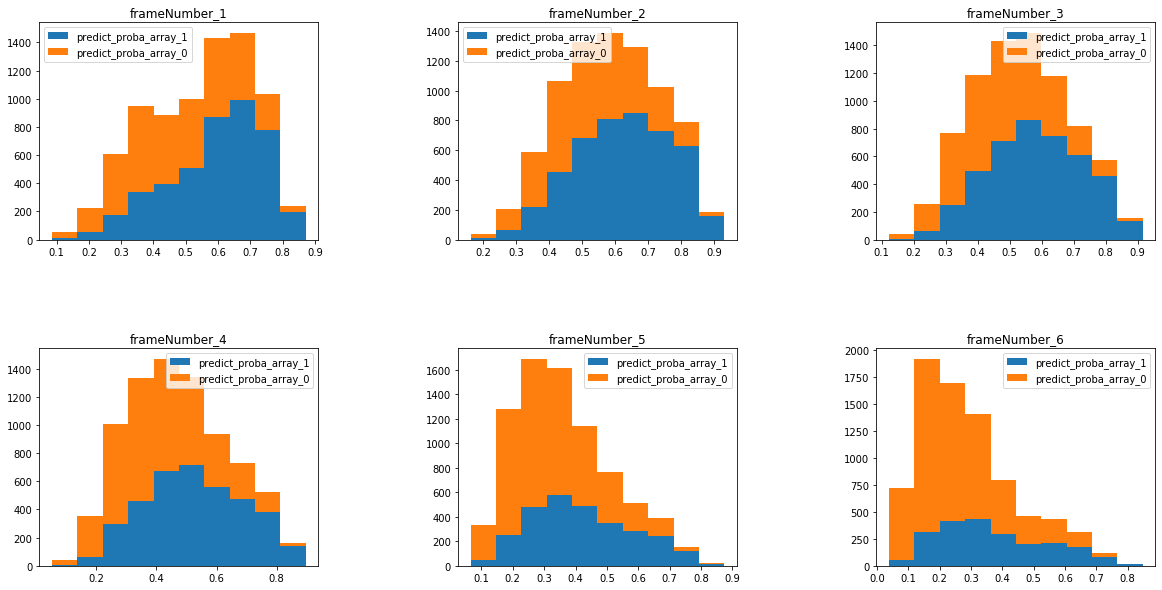

In [36]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    for j in range (coef.shape[1]):
        print(fv_list[j], coef[0, j], "\n")

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()


# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [37]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.321649    0.402131    0.825376    0.254647    0.281480    0.652611   
1       0.448191    0.506816    0.313364    0.827657    0.483235    0.133349   
2       0.596361    0.708395    0.359671    0.767960    0.216168    0.155926   
3       0.591243    0.670930    0.411563    0.388097    0.209606    0.527145   
4       0.496155    0.371915    0.373840    0.664272    0.328447    0.553370   
5       0.538209    0.623688    0.781978    0.423392    0.242998    0.161120   
6       0.316343    0.608172    0.549589    0.484435    0.457601    0.238215   
7       0.691218    0.685856    0.654749    0.437225    0.135419    0.232142   
8       0.733735    0.821634    0.521310    0.250129    0.215090    0.257719   
9       0.606944    0.524778    0.577141    0.371838    0.293887    0.414544   
10      0.412503    0.686019    0.452558    0.571249    0.467612    0.150922   
11      0.602594    0.424274    0.557906

In [38]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}".format(x_1, sum(return_boolean) / bet))
    print("確率{0}以上で1に単勝betした場合, 回収率は{1}".format(x_1, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.7008172796263864
確率0.6以上で1に単勝betした場合, 回収率は0.9107997664915353
確率0.7以上で1に単勝betした場合、的中率は0.7480916030534351
確率0.7以上で1に単勝betした場合, 回収率は0.9079516539440203
確率0.8以上で1に単勝betした場合、的中率は0.8134715025906736
確率0.8以上で1に単勝betした場合, 回収率は0.9150259067357513


In [39]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-56760, 回収率は0.7923161361141603
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-28960, 回収率は0.8057679409792086
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-9690, 回収率は0.835204081632653
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は-3170, 回収率は0.7616541353383459
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-21750, 回収率は0.8123382226056945
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-9120, 回収率は0.845945945945946
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-2450, 回収率は0.8870967741935484
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-1320, 回収率は0.7509433962264151
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-6680, 回収率は0.7639575971731449
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-1610, 回収率は0.8647058823529412
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-1840, 回収率は0.38666666666666666
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は-190, 回収率は0.7625


In [40]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-630750, 回収率は0.7654157988693842
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-264940, 回収率は0.767106188466948
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-78600, 回収率は0.7344594594594595
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-269150, 回収率は0.7743544600938967
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-95090, 回収率は0.7978528911564626
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-23320, 回収率は0.780827067669173
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-29260, 回収率は0.6926470588235294
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-7280, 回収率は0.6966666666666667
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は2850, 回収率は1.4453125


In [41]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-1374520, 回収率は0.7488268401432644
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-857450, 回収率は0.7662350054525627
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-507240, 回収率は0.7505213456620107
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-188600, 回収率は0.7902580071174378
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-69530, 回収率は0.7313369397217929
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-893930, 回収率は0.7589445583000755
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-556430, 回収率は0.7741761363636364
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-313410, 回収率は0.7668774174352871
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-119440, 回収率は0.790014064697609
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-47320, 回収率は0.6802702702702703
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-464770, 回収率は0.717705296404276
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-321570, 回収率は0.7058452250274424
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-179260, 回収率は0.6994299128101945
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-51190, 回収率は0.7823554421768707
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-18090, 回収率は0.6599624060150376
p1が0.8以上かつ、p2-6

In [42]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-232760, 回収率は0.8298786727086683
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-192780, 回収率は0.7688489208633094
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-32190, 回収率は0.7181260945709282
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-100920, 回収率は0.8364873622812703
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-79670, 回収率は0.8210467205750225
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-15080, 回収率は0.7307142857142858
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-10230, 回収率は0.8657480314960629
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は-13540, 回収率は0.7511029411764706
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-1820, 回収率は0.3933333333333333


In [43]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.3以上で3連単betすると収益は-1288120, 回収率は0.7451790306627102
p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-450130, 回収率は0.8285872048743336
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-194930, 回収率は0.8025025329280648
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-53280, 回収率は0.7691507798960139
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は2110, 回収率は1.0732638888888888
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-290, 回収率は0.5166666666666667
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-798980, 回収率は0.7637551744529864
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-282590, 回収率は0.8364830459437566
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-133390, 回収率は0.7896056782334385
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-32670, 回収率は0.76796875
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-2640, 回収率は0.8428571428571429
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-200, 回収率は0.0
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-299430, 回収率は0.7895487770593197
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-100010, 回収率は0.863
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-48310, 回収率は0.8175604229607251
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-10380, 回収率は0.81853146853

In [46]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx＿２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_3_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:

            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                    bet = bet + 200
                                    bet_num_1 = "1-{0}-{1}".format(j, k)
                                    bet_num_2 = "1-{0}-{1}".format(k, j)
                                    
                                    if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                        income = income + row["trifectaOdds"]
                                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                if (income / bet) > 1:
                    print("p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet))
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.4以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は300, 回収率は1.0035211267605635
p1が0.4以上かつ、p2が0.8以上かつp3が0.8で3連単betすると収益は640, 回収率は1.4
p1が0.5以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は4220, 回収率は1.0732638888888888
p1=0.7, p2=0.8, p3=0.8の時、投票候補なし
p1が0.8以上かつ、p2が0.5以上かつp3が0.6で3連単betすると収益は2130, 回収率は1.143918918918919
p1が0.8以上かつ、p2が0.5以上かつp3が0.8で3連単betすると収益は40, 回収率は1.04
p1が0.8以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は2130, 回収率は1.143918918918919
p1が0.8以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は3140, 回収率は2.1214285714285714
p1=0.8, p2=0.7, p3=0.7の時、投票候補なし
p1=0.8, p2=0.7, p3=0.8の時、投票候補なし
p1が0.8以上かつ、p2が0.8以上かつp3が0で3連単betすると収益は2850, 回収率は1.4453125
p1が0.8以上かつ、p2が0.8以上かつp3が0.1で3連単betすると収益は3250, 回収率は1.5416666666666667
p1が0.8以上かつ、p2が0.8以上かつp3が0.2で3連単betすると収益は2250, 回収率は1.5113636363636365
p1が0.8以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は40, 回収率は1.04
p1=0.8, p2=0.8, p3=0.7の時、投票候補なし
p1=0.8, p2=0.8, p3=0.8の時、投票候補なし


上の計算結果は、割と回収率あるところがあるようにみえるが、p1 = 0.6, 0.7の時、p2, -3に関わらず利益がマイナスになっていることに注意が必要。
これは、p1 = 0.8で切った場合に偶然いいところが極端に残った結果と考えられ、信頼度が低い。

In [48]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2着候補に, x_３以上の艇を3着候補にしてbet
x_1_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_3_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:

            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
                                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                if (income / bet) > 1:
                    print("p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet))
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.4以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は150, 回収率は1.0035211267605635
p1が0.4以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は1820, 回収率は1.2459459459459459
p1が0.4以上かつ、p2が0.8以上かつp3が0.8で3連単betすると収益は320, 回収率は1.4
p1が0.5以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は2110, 回収率は1.0732638888888888
p1が0.5以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は610, 回収率は1.1270833333333334
p1が0.6以上かつ、p2が0.4以上かつp3が0.8で3連単betすると収益は4080, 回収率は1.091685393258427
p1が0.6以上かつ、p2が0.7以上かつp3が0.8で3連単betすると収益は410, 回収率は1.1576923076923078
p1=0.7, p2=0.8, p3=0.8の時、投票候補なし
p1が0.8以上かつ、p2が0.4以上かつp3が0.7で3連単betすると収益は20, 回収率は1.0064516129032257
p1が0.8以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は990, 回収率は1.0589285714285714
p1が0.8以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は2160, 回収率は1.2918918918918918
p1が0.8以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は1570, 回収率は2.1214285714285714
p1=0.8, p2=0.7, p3=0.7の時、投票候補なし
p1=0.8, p2=0.7, p3=0.8の時、投票候補なし
p1が0.8以上かつ、p2が0.8以上かつp3が0.2で3連単betすると収益は320, 回収率は1.1454545454545455
p1が0.8以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は380, 回収率は1.2714285714285714
p1が0.8以上かつ、p2が0.8以上かつp3が0.4で3連単b

上の計算結果よりはマシだけど、p1 = 0.7の時に利益が出ないのが怪しい。他の部分の利益も、確率のブレの可能性がかなりある。

In [ ]:
# 1号艇以外の艇で3位以内率x_2以上が2艇あった場合に、XY(Z)のワイド
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_2 in x_2_list:

    income = 0
    bet = 0

    for index, row in for_calc_refund_rate_df.iterrows():
        for j in range(2, 7):
            if row["PredProb_{0}".format(j)] > x_2:
                for k in range(j, 7):
                    if k is not j and row["PredProb_{0}".format(k)] > x_2:
                        bet = bet + 100
                        bet_num = "{0}-{1}".format(j, k)
                        if row["wide_1"] == bet_num:
                            income = income + row["wideOdds_1"]
                        elif row["wide_2"] == bet_num:
                            income = income + row["wideOdds_2"]
                        elif row["wide_3"] == bet_num:
                            income = income + row["wideOdds_3"] 
    try:
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
    except ZeroDivisionError:
        print("投票候補なし")

In [28]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1-XYで3連複
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(j, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trio"] == bet_num:
                                    income = income + row["trioOdds"]
                                # print(bet_num, row["trio"], row["trioOdds"], bet, income)
        try:
            print("p1が{0}以上かつ、p2-6が{1}以上で3連複betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.5以上で3連複betすると収益は-102580, 回収率は0.7932271719411409
p1が0.5以上かつ、p2-6が0.6以上で3連複betすると収益は-28470, 回収率は0.7524347826086957
p1が0.5以上かつ、p2-6が0.7以上で3連複betすると収益は-2310, 回収率は0.835
p1が0.5以上かつ、p2-6が0.8以上で3連複betすると収益は-110, 回収率は0.725
p1が0.6以上かつ、p2-6が0.5以上で3連複betすると収益は-67540, 回収率は0.7868055555555555
p1が0.6以上かつ、p2-6が0.6以上で3連複betすると収益は-15620, 回収率は0.7790664780763791
p1が0.6以上かつ、p2-6が0.7以上で3連複betすると収益は-2760, 回収率は0.655
p1が0.6以上かつ、p2-6が0.8以上で3連複betすると収益は-100, 回収率は0.0
p1が0.7以上かつ、p2-6が0.5以上で3連複betすると収益は-24690, 回収率は0.8156086631814787
p1が0.7以上かつ、p2-6が0.6以上で3連複betすると収益は-5230, 回収率は0.8233108108108108
p1が0.7以上かつ、p2-6が0.7以上で3連複betすると収益は-970, 回収率は0.6870967741935484
投票候補なし
p1が0.8以上かつ、p2-6が0.5以上で3連複betすると収益は-320, 回収率は0.9755725190839695
p1が0.8以上かつ、p2-6が0.6以上で3連複betすると収益は730, 回収率は1.5214285714285714
p1が0.8以上かつ、p2-6が0.7以上で3連複betすると収益は-200, 回収率は0.0
投票候補なし


In [64]:
# 1の確率がx_1以下のとき、2-6号艇の値がx_2以上のものに対して単勝bet
x_1_list = [0.2, 0.3, 0.4, 0.5]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] < x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "{0}".format(j)
                        bet = bet + 100
                        if row["win"] == bet_num:
                            income = income + row["winOdds"]
        print("p1が{0}以下のとき、p2-6が{1}以上なら単勝betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.2以下のとき、p2-6が0.5以上なら単勝betすると収益は-1290, 回収率は0.9593059936908518
p1が0.2以下のとき、p2-6が0.6以上なら単勝betすると収益は-220, 回収率は0.9903083700440528
p1が0.2以下のとき、p2-6が0.7以上なら単勝betすると収益は-410, 回収率は0.9661157024793389
p1が0.2以下のとき、p2-6が0.8以上なら単勝betすると収益は720, 回収率は1.1263157894736842
p1が0.3以下のとき、p2-6が0.5以上なら単勝betすると収益は-13470, 回収率は0.9048728813559322
p1が0.3以下のとき、p2-6が0.6以上なら単勝betすると収益は-11600, 回収率は0.8836509528585758
p1が0.3以下のとき、p2-6が0.7以上なら単勝betすると収益は-3860, 回収率は0.9308243727598566
p1が0.3以下のとき、p2-6が0.8以上なら単勝betすると収益は-1710, 回収率は0.9113989637305699
p1が0.4以下のとき、p2-6が0.5以上なら単勝betすると収益は-50650, 回収率は0.8614984960350014
p1が0.4以下のとき、p2-6が0.6以上なら単勝betすると収益は-29750, 回収率は0.8803298471440064
p1が0.4以下のとき、p2-6が0.7以上なら単勝betすると収益は-6700, 回収率は0.9495101733232856
p1が0.4以下のとき、p2-6が0.8以上なら単勝betすると収益は-3390, 回収率は0.9254945054945055
p1が0.5以下のとき、p2-6が0.5以上なら単勝betすると収益は-94830, 回収率は0.8376198630136986
p1が0.5以下のとき、p2-6が0.6以上なら単勝betすると収益は-57100, 回収率は0.8514568158168574
p1が0.5以下のとき、p2-6が0.7以上なら単勝betすると収益は-18970, 回収率は0.9058093346573982
p1が0.5以下のとき、p2-6が0.8以上